# Xml-file Generation for Simulation ( hip joint without gap ) <a class="tocSkip"> 
This notebook explains a method to create a xml file of the finite element model

# imports and user-defined properties

In [3]:
import numpy as np
import meshplot as mp
from pathlib import Path
import os
import igl
import xml.etree.ElementTree as ET
import xml.dom.minidom
import matplotlib.pyplot as plt
import sys

sys.path.append('../')

import src

INPUT SUBJECT INFORMATION:
- model_id = choose between m1 -> m11 to select one of the detaset in the repository.
- user-defined names: these names belong to input bone models. 'l' and 'r' refer to the 'left' and the 'right' side of the body.
- i_dim, o_dim: the input and output dimension ( 'mm' = millimeters, 'm' = meters )
- o_format: the format you want the files to be save at ( '.obj' , '.stl' )

In [2]:
# model id
model_id = 'm1'  

# dimensions 
i_dim  = 'mm'     
o_dim  = 'm'

# file format and suffix
vol_i_format  = '.msh'
surf_i_format = '.npy'
o_format      = '.feb'

DIRECTORIES and PATHS:
- main_dir: locate this directory to where the libhip repository is cloned to.
- ftetwild_dir: locate this path to the 'build' folder of ftetwild.
- i_dir:  locate this directory to the input bone surface mesh files.
- o_dir:  locate this directory to where you. want the cleaned and remeshed bone models to be saved at.

In [5]:
# input and output
main_dir    = Path('..')
i_dir       = main_dir/ 'model_generation'/ 'volgen_output'/ model_id
nodal_i_dir = main_dir/ 'model_generation'/ 'mid_outputs'/ 'nodal_output'/ model_id
o_dir       = main_dir/ 'model_generation'/ 'simulation_output'/ model_id

# remove all files inside output directory if it exists, otherwise create it
if o_dir.is_dir():
    for file in o_dir.iterdir():
        if file.is_file():
            file.unlink()
else:
    o_dir.mkdir(exist_ok=False)

In [6]:
# input paths - volume meshes
input_pg_wg   = model_id + '_wog_pg'
input_legL_wg = model_id + '_wog_legL'
input_legR_wg = model_id + '_wog_legR'

input_pg_wg_path   = str((i_dir/ input_pg_wg).with_suffix(vol_i_format).resolve())
input_legL_wg_path = str((i_dir/ input_legL_wg).with_suffix(vol_i_format).resolve())
input_legR_wg_path = str((i_dir/ input_legR_wg).with_suffix(vol_i_format).resolve())

# input paths - contact surfaces
lmaster = input_pg_wg   + '_lsliding_faces'
rmaster = input_pg_wg   + '_rsliding_faces'
lslave  = input_legL_wg + '_sliding_faces'
rslave  = input_legR_wg + '_sliding_faces'

lmaster_path = str((nodal_i_dir/ lmaster).with_suffix(surf_i_format).resolve())
rmaster_path = str((nodal_i_dir/ rmaster).with_suffix(surf_i_format).resolve())
lslave_path  = str((nodal_i_dir/ lslave) .with_suffix(surf_i_format).resolve())
rslave_path  = str((nodal_i_dir/ rslave) .with_suffix(surf_i_format).resolve())

# input paths - element lengths
len_pg   = input_pg_wg   + '_element_idxs_list'
len_legL = input_legL_wg + '_element_idxs_list'
len_legR = input_legR_wg + '_element_idxs_list'

len_pg_path   = str((nodal_i_dir/ len_pg)  .with_suffix(surf_i_format).resolve())
len_legL_path = str((nodal_i_dir/ len_legL).with_suffix(surf_i_format).resolve())
len_legR_path = str((nodal_i_dir/ len_legR).with_suffix(surf_i_format).resolve())

# input path - fixed surfaces as boundary conditions
fix_pg     = input_pg_wg   + '_sacrum_minus_sharing_interfaces'
fix_lfemur = input_legL_wg + '_femur_faces'
fix_rfemur = input_legR_wg + '_femur_faces'

fix_pg_path = str((nodal_i_dir/ fix_pg).with_suffix(surf_i_format).resolve())
fix_lfemur_path = str((nodal_i_dir/ fix_lfemur).with_suffix(surf_i_format).resolve())
fix_rfemur_path = str((nodal_i_dir/ fix_rfemur).with_suffix(surf_i_format).resolve())

In [8]:
# output path - simulation file
output = model_id + '_wog_' + o_dim

output_path = str((o_dir/ output).with_suffix(o_format).resolve())

In [9]:
config_name  = model_id + '_config'
config_path  = str((main_dir/ 'config'/ config_name).with_suffix(".yml"))
config       = src.Config (config_path)

config_feb = config.sim_var

lf_bottom = config_feb.lf_z_coord
rf_bottom = config_feb.rf_z_coord

## read input data

In [10]:
# parts
pg_vertices,  pg_elements   = src.read_volume_mesh(input_pg_wg_path,  i_dim, o_dim)
legL_vertices,legL_elements = src.read_volume_mesh(input_legL_wg_path,i_dim, o_dim)
legR_vertices,legR_elements = src.read_volume_mesh(input_legR_wg_path,i_dim, o_dim)

# sliding_faces: master
lmaster_faces = np.load (lmaster_path, allow_pickle=True)
rmaster_faces = np.load (rmaster_path, allow_pickle=True)

# sliding_faces: slave
lslave_faces = np.load (lslave_path, allow_pickle=True)
rslave_faces = np.load (rslave_path, allow_pickle=True)

# fix pg
fix_pg_faces  = np.load (fix_pg_path, allow_pickle=True)

# fix femurs
fix_lfemur_faces  = np.load (fix_lfemur_path, allow_pickle=True)
fix_rfemur_faces  = np.load (fix_rfemur_path, allow_pickle=True)


In [11]:
# merge nodes
all_nodes = np.concatenate((pg_vertices, legL_vertices, legR_vertices))

# merge elements
all_elements = np.concatenate((pg_elements, 
                               legL_elements + len(pg_vertices), 
                               legR_elements  + len(pg_vertices) +len(legL_vertices)
                              ))

## element ids

In [12]:
# element length
len_pg   = np.load (len_pg_path, allow_pickle=True)
len_legL = np.load (len_legL_path, allow_pickle=True)
len_legR = np.load (len_legR_path, allow_pickle=True)

Id_lsi_cart = len_pg[0]
Id_rsi_cart = len_pg[1]
Id_lpelvic_cart = len_pg[2]
Id_rpelvic_cart = len_pg[3]
Id_pubic_cart = len_pg[4]
Id_sacrum_bone = len_pg[5]
Id_lpelvis_bone = len_pg[6]
Id_rpelvis_bone = len_pg[7]
#
Id_lfemoral_cart = len_legL[0]
Id_lfemur_bone = len_legL[1]
#
Id_rfemoral_cart = len_legR[0]
Id_rfemur_bone= len_legR[1]

## show sliding surfaces

In [16]:
frame = mp.plot (all_nodes, all_elements, c= src.bone, shading = src.sh_false  )
frame.add_mesh(all_nodes,lmaster_faces, c= src.pastel_orange, shading = src.sh_false) 
frame.add_mesh(all_nodes,rmaster_faces, c= src.pastel_orange, shading = src.sh_false) 
frame.add_mesh(all_nodes,lslave_faces + len(pg_vertices), c= src.pastel_yellow, shading = src.sh_false) 
frame.add_mesh(all_nodes,rslave_faces + len(pg_vertices)+ len(legL_vertices), c= src.pastel_yellow, shading = src.sh_false) 

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0003618…

4

## visualize fixed nodes

In [17]:
# left femur 
fix_pg_nodeset = np.unique(fix_pg_faces.flatten())

frame = mp.plot (all_nodes, all_elements, c= src.bone, shading = src.sh_false  )
frame.add_points(all_nodes[fix_pg_nodeset], shading = {"point_color": "red", "point_size": 0.01})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0003618…

1

## surfaces

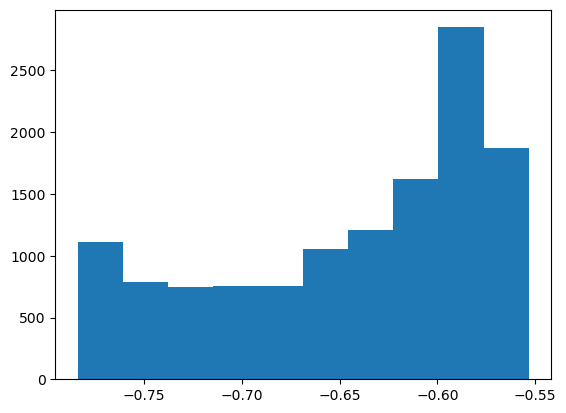

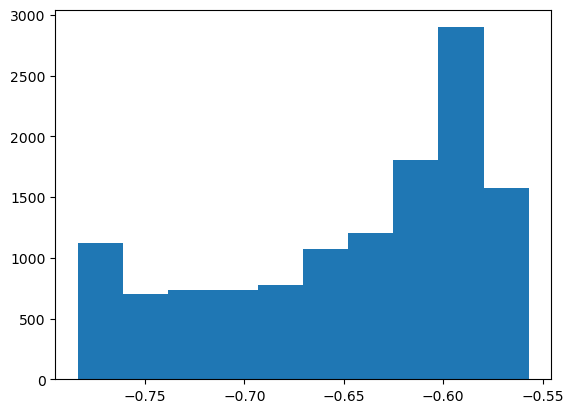

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0003618…

In [18]:
# left femur 
all_lfemur_faces = fix_lfemur_faces+len(pg_vertices)
triangleL_centroids = igl.barycenter(all_nodes, all_lfemur_faces)
lfemur_z_coord = triangleL_centroids[:,2]

plt.hist(lfemur_z_coord)
plt.show()

lidxs = np.where (lfemur_z_coord < lf_bottom)[0]
lfemur_fix_faces = all_lfemur_faces [lidxs]

# right femur 
all_rfemur_faces = fix_rfemur_faces+len(pg_vertices)+len(legL_vertices)
triangleR_centroids = igl.barycenter(all_nodes, all_rfemur_faces)
rfemur_z_coord = triangleR_centroids[:,2]

plt.hist(rfemur_z_coord)
plt.show()

ridxs = np.where (rfemur_z_coord < rf_bottom)[0]
rfemur_fix_faces = all_rfemur_faces [ridxs]

frame = mp.plot (all_nodes, all_elements, c= src.bone, shading = src.sh_false  )
frame.add_mesh(all_nodes, lfemur_fix_faces, c= src.sweet_pink, shading = src.sh_false)
frame.add_mesh(all_nodes, rfemur_fix_faces, c= src.sweet_pink, shading = src.sh_false)

fix_lf_nodeset = np.unique(lfemur_fix_faces.flatten())
fix_rf_nodeset = np.unique(rfemur_fix_faces.flatten())

# index adjustments 

In [ ]:
# object elements
legL_elements = legL_elements + 1
legR_elements = legR_elements + 1
pg_elements   = pg_elements + 1

all_elements  = all_elements + 1

# sliding surfaces
lmaster_faces = lmaster_faces + 1
rmaster_faces = rmaster_faces + 1
lslave_faces  = lslave_faces + 1
rslave_faces  = rslave_faces + 1

# fixed surfaces
fix_pg_nodeset = fix_pg_nodeset + 1
fix_lf_nodeset = fix_lf_nodeset + 1
fix_rf_nodeset = fix_rf_nodeset + 1

# xml document

In [ ]:
xml_doc = ET.Element('febio_spec', {'version':'2.5'})

moduleData = {'type':'solid'}
ET.SubElement(xml_doc,'Module', moduleData)


## Control

In [ ]:
controlElement = ET.Element('Control')

time_steps = ET.Element ('time_steps')
time_steps.text = str(100)
controlElement.append(time_steps)

step_size = ET.Element('step_size')
step_size.text = str(0.01)
controlElement.append(step_size)

max_refs = ET.Element('max_refs')
max_refs.text = str(15)
controlElement.append(max_refs)

max_ups = ET.Element('max_ups')
max_ups.text = str(10)
controlElement.append(max_ups)

diverge_reform = ET.Element('diverge_reform')
diverge_reform.text = str(1)
controlElement.append(diverge_reform)

reform_each_time_step = ET.Element('reform_each_time_step')
reform_each_time_step.text = str(1)
controlElement.append(reform_each_time_step)

dtol = ET.Element('dtol')
dtol.text = str(0.001)
controlElement.append(dtol)

etol = ET.Element('etol')
etol.text =str( 0.01)
controlElement.append(etol)

rtol = ET.Element('rtol')
rtol.text = str(0)
controlElement.append(rtol)

lstol = ET.Element('lstol')
lstol.text = str(0.9)
controlElement.append(lstol)

min_residual = ET.Element('min_residual')
min_residual.text = str(1e-20)
controlElement.append(min_residual)

qnmethod = ET.Element('qnmethod')
qnmethod.text = str(0)
controlElement.append(qnmethod)

time_stepper = ET.Element('time_stepper')

dtmin = ET.Element('dtmin')
dtmin.text = str(0.1)
time_stepper.append(dtmin)

dtmax = ET.Element('dtmax')
dtmax.text = str(0.1)
time_stepper.append(dtmax)

max_retries = ET.Element('max_retries')
max_retries.text = str(5)
time_stepper.append(max_retries)

opt_iter = ET.Element('opt_iter')
opt_iter.text = str(10)
time_stepper.append(opt_iter)

controlElement.append(time_stepper)

analysisData = {'type':'dynamic'}
ET.SubElement(controlElement,'analysis', analysisData) 

alpha = ET.Element('alpha')
alpha.text = str(1)
controlElement.append(alpha)

beta = ET.Element('beta')
beta.text = str(0.25)
controlElement.append(beta)

gamma = ET.Element('gamma')
gamma.text = str(0.5)
controlElement.append(gamma)

symmetric_stiffness = ET.Element('symmetric_stiffness')
symmetric_stiffness.text = str(0)
controlElement.append(symmetric_stiffness)

xml_doc.append(controlElement)

## Globals

In [ ]:
globalsElement = ET.Element('Globals')
xml_doc.append(globalsElement)


### Constants

In [ ]:
xml_const = ET.Element ('Constants')

T = ET.Element('T')
T.text = str(0)
xml_const.append(T)

R = ET.Element('R')
R.text = str(0)
xml_const.append(R)

Fc = ET.Element('Fc')
Fc.text = str(0)
xml_const.append(Fc)

globalsElement.append(xml_const)

## Material

In [ ]:
materialElement= ET.Element ('Material')
xml_doc.append(materialElement)


### cartilage material

In [ ]:
xml_materialData1 = {'id':'1', 'name':'mt-pg-cartilage', 'type':'neo-Hookean'}

mt1Element = ET.Element ('material',xml_materialData1 )

density1 = ET.Element('density')
density1.text = str(500)
mt1Element.append(density1)

E1 = ET.Element('E')
E1.text = str(1.2e+07)
mt1Element.append(E1)

v1 = ET.Element('v')
v1.text = str(0.45)
mt1Element.append(v1)

materialElement.append(mt1Element)


In [ ]:
xml_materialData2 = {'id':'2', 'name':'mt-f-cartilage', 'type':'neo-Hookean'}

mt2Element = ET.Element ('material',xml_materialData2 )

density2 = ET.Element('density')
density2.text = str(500)
mt2Element.append(density2)

E2 = ET.Element('E')
E2.text = str(1.2e+07)
mt2Element.append(E2)

v2 = ET.Element('v')
v2.text = str(0.45)
mt2Element.append(v2)

materialElement.append(mt2Element)

### bone material

In [ ]:
xml_materialData3 = {'id':'3', 'name':'mt-pg-bone', 'type':'neo-Hookean'}

mt3Element = ET.Element ('material', xml_materialData3 )

density3 = ET.Element('density')
density3.text = str(1640)
mt3Element.append(density3)

E3 = ET.Element('E')
E3.text = str(1.7e+10)
mt3Element.append(E3)

v3 = ET.Element('v')
v3.text = str(0.3)
mt3Element.append(v3)

materialElement.append(mt3Element)

In [ ]:
xml_materialData4 = {'id':'4', 'name':'mt-f-bone', 'type':'neo-Hookean'}

mt4Element = ET.Element ('material', xml_materialData4 )

density4 = ET.Element('density')
density4.text = str(1640)
mt4Element.append(density4)

E4 = ET.Element('E')
E4.text = str(1.7e+10)
mt4Element.append(E4)

v4 = ET.Element('v')
v4.text = str(0.3)
mt4Element.append(v4)

materialElement.append(mt4Element)

In [ ]:
xml_materialData5 = {'id':'5', 'name':'rigid', 'type':'rigid body'}

mt5Element = ET.Element ('material', xml_materialData5 )

density5 = ET.Element('density')
density5.text = str(1)
mt5Element.append(density5)

com5 = ET.Element('center_of_mass')
com5.text = str('0,0,0')
mt5Element.append(com5)

materialElement.append(mt5Element)

## Geometry

In [ ]:
geometryElement = ET.Element('Geometry')
xml_doc.append(geometryElement)

###  Nodes

In [ ]:
# part1: girdle_without_gap
nodes1data = {'name': model_id +'_girdle_wo_gap'}
xml_Nodes1 = ET.Element('Nodes', nodes1data) 
for i in range(1,len(pg_vertices)+1): 
    barNodesChild1 = src.getNodeXmlElement(i, all_nodes[i-1]) 
    xml_Nodes1.append(barNodesChild1)
geometryElement.append(xml_Nodes1)

# part2: left leg
nodes2data = {'name': model_id +'_left_leg_wo_gap'}
xml_Nodes2 = ET.Element('Nodes', nodes2data ) 
for i in range(len(pg_vertices)+1,len(pg_vertices)+len(legL_vertices)+1):
    barNodesChild2 = src.getNodeXmlElement(i, all_nodes[i-1]) 
    xml_Nodes2.append(barNodesChild2)
geometryElement.append(xml_Nodes2)

# part3: right leg
nodes3data = {'name': model_id +'_right_leg_wo_gap'}
xml_Nodes3 = ET.Element('Nodes',nodes3data) 

for i in range(len(pg_vertices)+len(legL_vertices)+1,len(pg_vertices)+len(legL_vertices)+len(legR_vertices)+1): 
    barNodesChild3 = src.getNodeXmlElement(i, all_nodes[i-1]) 
    xml_Nodes3.append(barNodesChild3)
    
geometryElement.append(xml_Nodes3)

 ### Elements

In [ ]:
# ID1: lsi_cart
xml_elementsData1 = { 'type':'tet4', 'mat':'1', 'name': 'lsi_cart'} 
xml_Elements1 = ET.Element('Elements', xml_elementsData1)
for i in range(1, 
               Id_lsi_cart+1): 
    elemXmlElement1 = src.getElemXmlElement(i, all_elements[i-1])
    xml_Elements1.append(elemXmlElement1)
geometryElement.append(xml_Elements1)

# ID2: rsi cart
xml_elementsData2 = {'type':'tet4', 'mat':'1','name': 'rsi_cart'}  
xml_Elements2 = ET.Element('Elements', xml_elementsData2)
for i in range(Id_lsi_cart+1, 
               Id_lsi_cart+Id_rsi_cart+1):
    elemXmlElement2 = src.getElemXmlElement(i, all_elements[i-1])
    xml_Elements2.append(elemXmlElement2)
geometryElement.append(xml_Elements2)

# ID3: lpelvic_cart
xml_elementsData3 = {'type':'tet4','mat':'1','name': 'lpelvic_cart'}  
xml_Elements3 = ET.Element('Elements', xml_elementsData3)
for i in range(Id_lsi_cart+Id_rsi_cart+1, 
               Id_lsi_cart+Id_rsi_cart+Id_lpelvic_cart+1):
    elemXmlElement3 = src.getElemXmlElement(i, all_elements[i-1])
    xml_Elements3.append(elemXmlElement3)
geometryElement.append(xml_Elements3)

# ID4: rpelvic_cart
xml_elementsData4 = {'type':'tet4','mat':'1','name': 'rpelvic_cart'} 
xml_Elements4 = ET.Element('Elements', xml_elementsData4)
for i in range(Id_lsi_cart+Id_rsi_cart+Id_lpelvic_cart+1,
               Id_lsi_cart+Id_rsi_cart+Id_lpelvic_cart+Id_rpelvic_cart+1):
    elemXmlElement4 = src.getElemXmlElement(i, all_elements[i-1])
    xml_Elements4.append(elemXmlElement4)
geometryElement.append(xml_Elements4)

# ID5: pubic_cart
xml_elementsData5 = {'type':'tet4','mat':'1','name': 'pubic_cart'} 
xml_Elements5 = ET.Element('Elements', xml_elementsData5)
for i in range(Id_lsi_cart+Id_rsi_cart+Id_lpelvic_cart+Id_rpelvic_cart+1,
               Id_lsi_cart+Id_rsi_cart+Id_lpelvic_cart+Id_rpelvic_cart+Id_pubic_cart+1):
    elemXmlElement5 = src.getElemXmlElement(i, all_elements[i-1])
    xml_Elements5.append(elemXmlElement5)
geometryElement.append(xml_Elements5)

# ID6: sacrum bone
xml_elementsData6 = {'type':'tet4','mat':'3','name': 'sacrum_bone'} 
xml_Elements6 = ET.Element('Elements', xml_elementsData6)
for i in range(Id_lsi_cart+Id_rsi_cart+Id_lpelvic_cart+Id_rpelvic_cart+Id_pubic_cart+1, 
               Id_lsi_cart+Id_rsi_cart+Id_lpelvic_cart+Id_rpelvic_cart+Id_pubic_cart+Id_sacrum_bone+1):
    elemXmlElement6 = src.getElemXmlElement(i, all_elements[i-1])
    xml_Elements6.append(elemXmlElement6)
geometryElement.append(xml_Elements6)

# ID7: lpelvis bone
xml_elementsData7 = {'type':'tet4','mat':'3','name': 'lpelvis_bone'} 
xml_Elements7 = ET.Element('Elements', xml_elementsData7)
for i in range(Id_lsi_cart+Id_rsi_cart+Id_lpelvic_cart+Id_rpelvic_cart+Id_pubic_cart+Id_sacrum_bone+1, 
               Id_lsi_cart+Id_rsi_cart+Id_lpelvic_cart+Id_rpelvic_cart+Id_pubic_cart+Id_sacrum_bone+Id_lpelvis_bone+1):
    elemXmlElement7 = src.getElemXmlElement(i, all_elements[i-1])
    xml_Elements7.append(elemXmlElement7)
geometryElement.append(xml_Elements7)

# ID8: rpelvis
xml_elementsData8 = {'type':'tet4','mat':'3','name': 'rpelvis_bone'} 
xml_Elements8 = ET.Element('Elements', xml_elementsData8)
for i in range(Id_lsi_cart+Id_rsi_cart+Id_lpelvic_cart+Id_rpelvic_cart+Id_pubic_cart+Id_sacrum_bone+Id_lpelvis_bone+1, 
               Id_lsi_cart+Id_rsi_cart+Id_lpelvic_cart+Id_rpelvic_cart+Id_pubic_cart+Id_sacrum_bone+Id_lpelvis_bone+Id_rpelvis_bone+1):
    elemXmlElement8 = src.getElemXmlElement(i , all_elements[i-1])
    xml_Elements8.append(elemXmlElement8)
geometryElement.append(xml_Elements8)

# Id9: lfemoral cart
xml_elementsData9 = {'type':'tet4','mat':'2','name': 'lfemoral_cart'} 
xml_Elements9 = ET.Element('Elements', xml_elementsData9)
for i in range(Id_lsi_cart+Id_rsi_cart+Id_lpelvic_cart+Id_rpelvic_cart+Id_pubic_cart+Id_sacrum_bone+Id_lpelvis_bone+Id_rpelvis_bone+1, 
               Id_lsi_cart+Id_rsi_cart+Id_lpelvic_cart+Id_rpelvic_cart+Id_pubic_cart+Id_sacrum_bone+Id_lpelvis_bone+Id_rpelvis_bone+Id_lfemoral_cart+1):
    elemXmlElement9 = src.getElemXmlElement(i , all_elements[i-1])
    xml_Elements9.append(elemXmlElement9)
geometryElement.append(xml_Elements9)

# ID10: left femur bone 
xml_elementsData10 = {'type':'tet4','mat':'4','name': 'lfemur_bone'} 
xml_Elements10 = ET.Element('Elements', xml_elementsData10)
for i in range(Id_lsi_cart+Id_rsi_cart+Id_lpelvic_cart+Id_rpelvic_cart+Id_pubic_cart+Id_sacrum_bone+Id_lpelvis_bone+Id_rpelvis_bone+Id_lfemoral_cart+1, 
               Id_lsi_cart+Id_rsi_cart+Id_lpelvic_cart+Id_rpelvic_cart+Id_pubic_cart+Id_sacrum_bone+Id_lpelvis_bone+Id_rpelvis_bone+Id_lfemoral_cart+Id_lfemur_bone+1):
    elemXmlElement10 = src.getElemXmlElement(i , all_elements[i-1])
    xml_Elements10.append(elemXmlElement10)
geometryElement.append(xml_Elements10)

# ID11: right femoral cart
xml_elementsData11 = {'type':'tet4','mat':'2','name': 'rfemoral_cart'} 
xml_Elements11 = ET.Element('Elements', xml_elementsData11)
for i in range(Id_lsi_cart+Id_rsi_cart+Id_lpelvic_cart+Id_rpelvic_cart+Id_pubic_cart+Id_sacrum_bone+Id_lpelvis_bone+Id_rpelvis_bone+Id_lfemoral_cart+Id_lfemur_bone+1,
              Id_lsi_cart+Id_rsi_cart+Id_lpelvic_cart+Id_rpelvic_cart+Id_pubic_cart+Id_sacrum_bone+Id_lpelvis_bone+Id_rpelvis_bone+Id_lfemoral_cart+Id_lfemur_bone+Id_rfemoral_cart+1):
    elemXmlElement11 = src.getElemXmlElement(i , all_elements[i-1])
    xml_Elements11.append(elemXmlElement11)
geometryElement.append(xml_Elements11)

# ID12: right femur
xml_elementsData12 = {'type':'tet4','mat':'4','name': 'rfemur_bone'} 
xml_Elements12 = ET.Element('Elements', xml_elementsData12)
for i in range(Id_lsi_cart+Id_rsi_cart+Id_lpelvic_cart+Id_rpelvic_cart+Id_pubic_cart+Id_sacrum_bone+Id_lpelvis_bone+Id_rpelvis_bone+Id_lfemoral_cart+Id_lfemur_bone+Id_rfemoral_cart+1,
              Id_lsi_cart+Id_rsi_cart+Id_lpelvic_cart+Id_rpelvic_cart+Id_pubic_cart+Id_sacrum_bone+Id_lpelvis_bone+Id_rpelvis_bone+Id_lfemoral_cart+Id_lfemur_bone+Id_rfemoral_cart+Id_rfemur_bone+1):
    elemXmlElement12 = src.getElemXmlElement(i , all_elements[i-1])
    xml_Elements12.append(elemXmlElement12)
geometryElement.append(xml_Elements12)

### fixed pg nodesets

In [ ]:
xml_NodeSetdata0 = {'name':'fix-pg'}

xml_NodeSet0 = ET.Element('NodeSet', xml_NodeSetdata0 ) 

elementId = fix_pg_nodeset
# NodeSetData = {'id':str(elementId)}

for i in range (len(elementId)):
    nodesetData = {'id':str(elementId[i])}
    xmlElement = ET.SubElement(xml_NodeSet0,'node', nodesetData) 
    
geometryElement.append( xml_NodeSet0 )

### fixed femur nodesets

In [ ]:
# fixed lfemur ground
xml_Nodesetdata1 = {'name':'lfemur_g'}
xml_NodeSet1 = ET.Element('NodeSet', xml_Nodesetdata1) 

elementId1 = fix_lf_nodeset

for i in range (len(elementId1)):
    nodesetData1 = {'id':str(elementId1[i])}
    xmlElement = ET.SubElement(xml_NodeSet1,'node', nodesetData1) 

geometryElement.append( xml_NodeSet1 )

# fixed rfemur ground
xml_Nodesetdata2 = {'name':'rfemur_g'}
xml_NodeSet2 = ET.Element('NodeSet', xml_Nodesetdata2) 

elementId2 = fix_rf_nodeset

for i in range (len(elementId2)):
    nodesetData2 = {'id':str(elementId2[i])}
    xmlElement = ET.SubElement(xml_NodeSet2,'node', nodesetData2) 

geometryElement.append( xml_NodeSet2 )

### Surface selections

In [ ]:
# left sliding master
xml_Surfacedata6 = {'name':'lsliding_master'}
xml_Surface6 = ET.Element('Surface', xml_Surfacedata6) 
for i in range(1, len(lmaster_faces)+1): 
    barSurfaceChild = src.getSurfaceXmlElement(i, lmaster_faces[i-1]) 
    xml_Surface6.append(barSurfaceChild)
geometryElement.append( xml_Surface6 )

# left sliding slave 
xml_Surfacedata7 = {'name':'lsliding_slave'}
xml_Surface7 = ET.Element('Surface', xml_Surfacedata7) 
for i in range(1, len(lslave_faces)+1): 
    barSurfaceChild = src.getSurfaceXmlElement(i, lslave_faces[i-1] + len(pg_vertices)) 
    xml_Surface7.append(barSurfaceChild)
geometryElement.append( xml_Surface7 )

# right sliding master rfc
xml_Surfacedata8 = {'name':'rsliding_master'}
xml_Surface8 = ET.Element('Surface', xml_Surfacedata8) 
for i in range(1, len(rmaster_faces)+1): 
    barSurfaceChild = src.getSurfaceXmlElement(i, rmaster_faces[i-1]) 
    xml_Surface8.append(barSurfaceChild)
geometryElement.append( xml_Surface8 )

# right sliding slave rpc
xml_Surfacedata9 = {'name':'rsliding_slave'}
xml_Surface9 = ET.Element('Surface', xml_Surfacedata9) 
for i in range(1, len(rslave_faces)+1):
    barSurfaceChild = src.getSurfaceXmlElement(i, rslave_faces[i-1] + len(pg_vertices)+ len(legL_vertices)) 
    xml_Surface9.append(barSurfaceChild)
geometryElement.append( xml_Surface9 )

In [ ]:
# lsliding
xml_Surfacepair1data = {'name':'lsliding'}
xml_Surfacepair1 = ET.Element('SurfacePair', xml_Surfacepair1data) 

master = {'surface':'lsliding_master'}
ET.SubElement(xml_Surfacepair1,'master', master) 

slave = {'surface':'lsliding_slave'}
ET.SubElement(xml_Surfacepair1,'slave', slave) 

geometryElement.append( xml_Surfacepair1 )

# rsliding
xml_Surfacepair2data = {'name':'rsliding'}
xml_Surfacepair2 = ET.Element('SurfacePair', xml_Surfacepair2data) 

master = {'surface':'rsliding_master'}
ET.SubElement(xml_Surfacepair2,'master', master) 

slave = {'surface':'rsliding_slave'}
ET.SubElement(xml_Surfacepair2,'slave', slave) 

geometryElement.append( xml_Surfacepair2 )

## Boundary

In [ ]:
boundaryElement = ET.Element('Boundary')
xml_doc.append(boundaryElement)

# for pg
boundaryData1 = {'name':'fix-pg', 'bc':'x,y,z', 'node_set': 'fix-pg'}
ET.SubElement (boundaryElement, 'fix', boundaryData1  )

# for rigid contact
boundaryData2 = {'name':'c-lfemur-g', 'rb':'5', 'node_set': 'lfemur_g'}
ET.SubElement (boundaryElement, 'rigid', boundaryData2  )

boundaryData3 = {'name':'c-rfemur-g', 'rb':'5', 'node_set': 'rfemur_g'}
ET.SubElement (boundaryElement, 'rigid', boundaryData3  )

# rigid fixed boundary
boundaryData4 = {'mat':'5'}
xml_rigidbody = ET.Element('rigid_body', boundaryData4 ) 

x = {'bc':'x'}
y = {'bc':'y'}
Rx = {'bc':'Rx'}
Ry = {'bc':'Ry'}
Rz = {'bc':'Rz'}
ET.SubElement(xml_rigidbody ,'fixed', x)
ET.SubElement(xml_rigidbody ,'fixed', y)
ET.SubElement(xml_rigidbody ,'fixed', Rx)
ET.SubElement(xml_rigidbody ,'fixed', Ry)
ET.SubElement(xml_rigidbody ,'fixed', Rz)

boundaryElement.append(xml_rigidbody)

# prescribed body weight
boundaryData5 = {'mat':'5'}
xml_rigidbody2 = ET.Element('rigid_body', boundaryData5 ) 

forcedata = {'bc':'z', 'lc':'1'}
xml_force = ET.Element('force', forcedata ) 
xml_force.text = str('430')

xml_rigidbody2.append(xml_force)
boundaryElement.append(xml_rigidbody2)


## Contact

In [ ]:
contactElement = ET.Element('Contact')
xml_doc.append(contactElement)

# lsliding
contactdata0 = {'type':'sliding-elastic', 'name': "lsliding", 'surface_pair':'lsliding'}
contactdata0Element = ET.Element('contact', contactdata0)
contactElement.append(contactdata0Element)

# rsliding
contactdata1 = {'type':'sliding-elastic', 'name': "rsliding", 'surface_pair':'rsliding'}
contactdata1Element = ET.Element('contact', contactdata1)
contactElement.append(contactdata1Element)

# laugon
laugon = ET.Element ('laugon')
laugon.text = str(1)
contactdata0Element.append(laugon)
contactdata1Element.append(laugon)

# tolerance
tolerance = ET.Element ('tolerance')
tolerance.text = str(0.2)
contactdata0Element.append(tolerance)
contactdata1Element.append(tolerance)

# gaptol
gaptol = ET.Element ('gaptol')
gaptol.text = str(0)
contactdata0Element.append(gaptol)
contactdata1Element.append(gaptol)

# penalty
penalty = ET.Element ('penalty')
penalty.text = str(1)
contactdata0Element.append(penalty)
contactdata1Element.append(penalty)

# auto_penalty
auto_penalty = ET.Element ('auto_penalty')
auto_penalty.text = str(1)
contactdata0Element.append(auto_penalty)
contactdata1Element.append(auto_penalty)

# two_pass
two_pass = ET.Element ('two_pass')
two_pass.text = str(0)
contactdata0Element.append(two_pass)
contactdata1Element.append(two_pass)

# search_tol
search_tol = ET.Element ('search_tol')
search_tol.text = str(0.01)
contactdata0Element.append(search_tol)
contactdata1Element.append(search_tol)

# symmetric_stiffness
sym_stiff = ET.Element ('symmetric_stiffness')
sym_stiff.text = str(0)
contactdata0Element.append(sym_stiff)
contactdata1Element.append(sym_stiff)

# search_radius
search_rad = ET.Element ('search_radius')
search_rad.text = str(1)
contactdata0Element.append(search_rad)
contactdata1Element.append(search_rad)

# seg_up
seg_up = ET.Element ('seg_up')
seg_up.text = str(3)
contactdata0Element.append(seg_up)
contactdata1Element.append(seg_up)

# tension
tension = ET.Element ('tension')
tension.text = str(0)
contactdata0Element.append(tension)
contactdata1Element.append(tension)

# minaug
minaug = ET.Element ('minaug')
minaug.text = str(3)
contactdata0Element.append(minaug)
contactdata1Element.append(minaug)

# maxaug
maxaug = ET.Element ('maxaug')
maxaug.text = str(10)
contactdata0Element.append(maxaug)
contactdata1Element.append(maxaug)

# fric_coeff
fric_coeff = ET.Element ('fric_coeff')
fric_coeff.text = str(0)
contactdata0Element.append(fric_coeff)
contactdata1Element.append(fric_coeff)


# smooth_aug
smooth_aug = ET.Element ('smooth_aug')
smooth_aug.text = str(0)
contactdata0Element.append(smooth_aug)
contactdata1Element.append(smooth_aug)

# node_reloc
node_reloc = ET.Element ('node_reloc')
node_reloc.text = str(0)
contactdata0Element.append(node_reloc)
contactdata1Element.append(node_reloc)

# flip_primary
flip_primary = ET.Element ('flip_primary')
flip_primary.text = str(0)
contactdata0Element.append(flip_primary)
contactdata1Element.append(flip_primary)

# flip_secondary
flip_secondary= ET.Element ('flip_secondary')
flip_secondary.text = str(0)
contactdata0Element.append(flip_secondary)
contactdata1Element.append(flip_secondary)

# knmult
knmult= ET.Element ('knmult')
knmult.text = str(0)
contactdata0Element.append(knmult)
contactdata1Element.append(knmult)

# update_penalty
update_penalty = ET.Element ('update_penalty')
update_penalty.text = str(0)
contactdata0Element.append(update_penalty)
contactdata1Element.append(update_penalty)

# shell_bottom_primary
shell_bottom_primary = ET.Element ('shell_bottom_primary')
shell_bottom_primary.text = str(0)
contactdata0Element.append(shell_bottom_primary)
contactdata1Element.append(shell_bottom_primary)

# shell_bottom_secondary
shell_bottom_secondary = ET.Element ('shell_bottom_secondary')
shell_bottom_secondary.text = str(0)
contactdata0Element.append(shell_bottom_secondary)
contactdata1Element.append(shell_bottom_secondary)

## LoadData

In [ ]:
loaddataElement = ET.Element('LoadData')
xml_doc.append(loaddataElement)

# id 1 x
loadcurveData1 = {'id':'1', 'type':'smooth'}
loadcurveElement1 = ET.Element('loadcurve', loadcurveData1)
loaddataElement.append(loadcurveElement1)

point0Element1 = ET.Element('point')
point0Element1.text = str('0,0')
loadcurveElement1.append(point0Element1)

point1Element1 = ET.Element('point')
point1Element1.text = str('1,1')

loadcurveElement1.append(point1Element1)

## Output

In [ ]:
outputElement = ET.Element ( 'Output')
xml_doc.append(outputElement)

# plotfile
plotfileData = {'type':'febio'}
plotfileElement = ET.Element('plotfile', plotfileData)

var0Data = {'type':'displacement'}
var1Data = {'type':'contact force'}
var2Data = {'type':'contact area'}
var3Data = {'type':'contact pressure'}
var4Data = {'type':'stress'}

ET.SubElement(plotfileElement, 'var', var0Data)
ET.SubElement(plotfileElement, 'var', var1Data)
ET.SubElement(plotfileElement, 'var', var2Data)
ET.SubElement(plotfileElement, 'var', var3Data)
ET.SubElement(plotfileElement, 'var', var4Data)

outputElement.append(plotfileElement)

#logfile
logfileElement = ET.Element('logfile')

logfileData = {'data': 'sx;sy;sz;sxy;syz;sxz', 'file':model_id + '_wo_gap_' + o_dim + ".csv"}

ET.SubElement(logfileElement, 'element_data', logfileData)

outputElement.append(logfileElement)

## save the xml document

In [ ]:
src.xmlElementWriter(xml_doc, output_path)